Worst performing layers for Qwen-2.5-7B-Instruct: [27, 23, 2, 22, 21, 25, 1, 24, 13, 20]
Worst performing layers for Llama-3.1-8B-Instruct: [1, 31, 13, 15, 12, 16, 14, 18, 2, 11]
Worst performing layers for Mistral-7B-Instruct-v0.3: [1, 0, 29, 20, 17, 15, 16, 9, 14, 6]
✓ Multi-model visualization saved to: /scratch/ss13750/nnsight/viz/multi_model_ablation_comparison.pdf


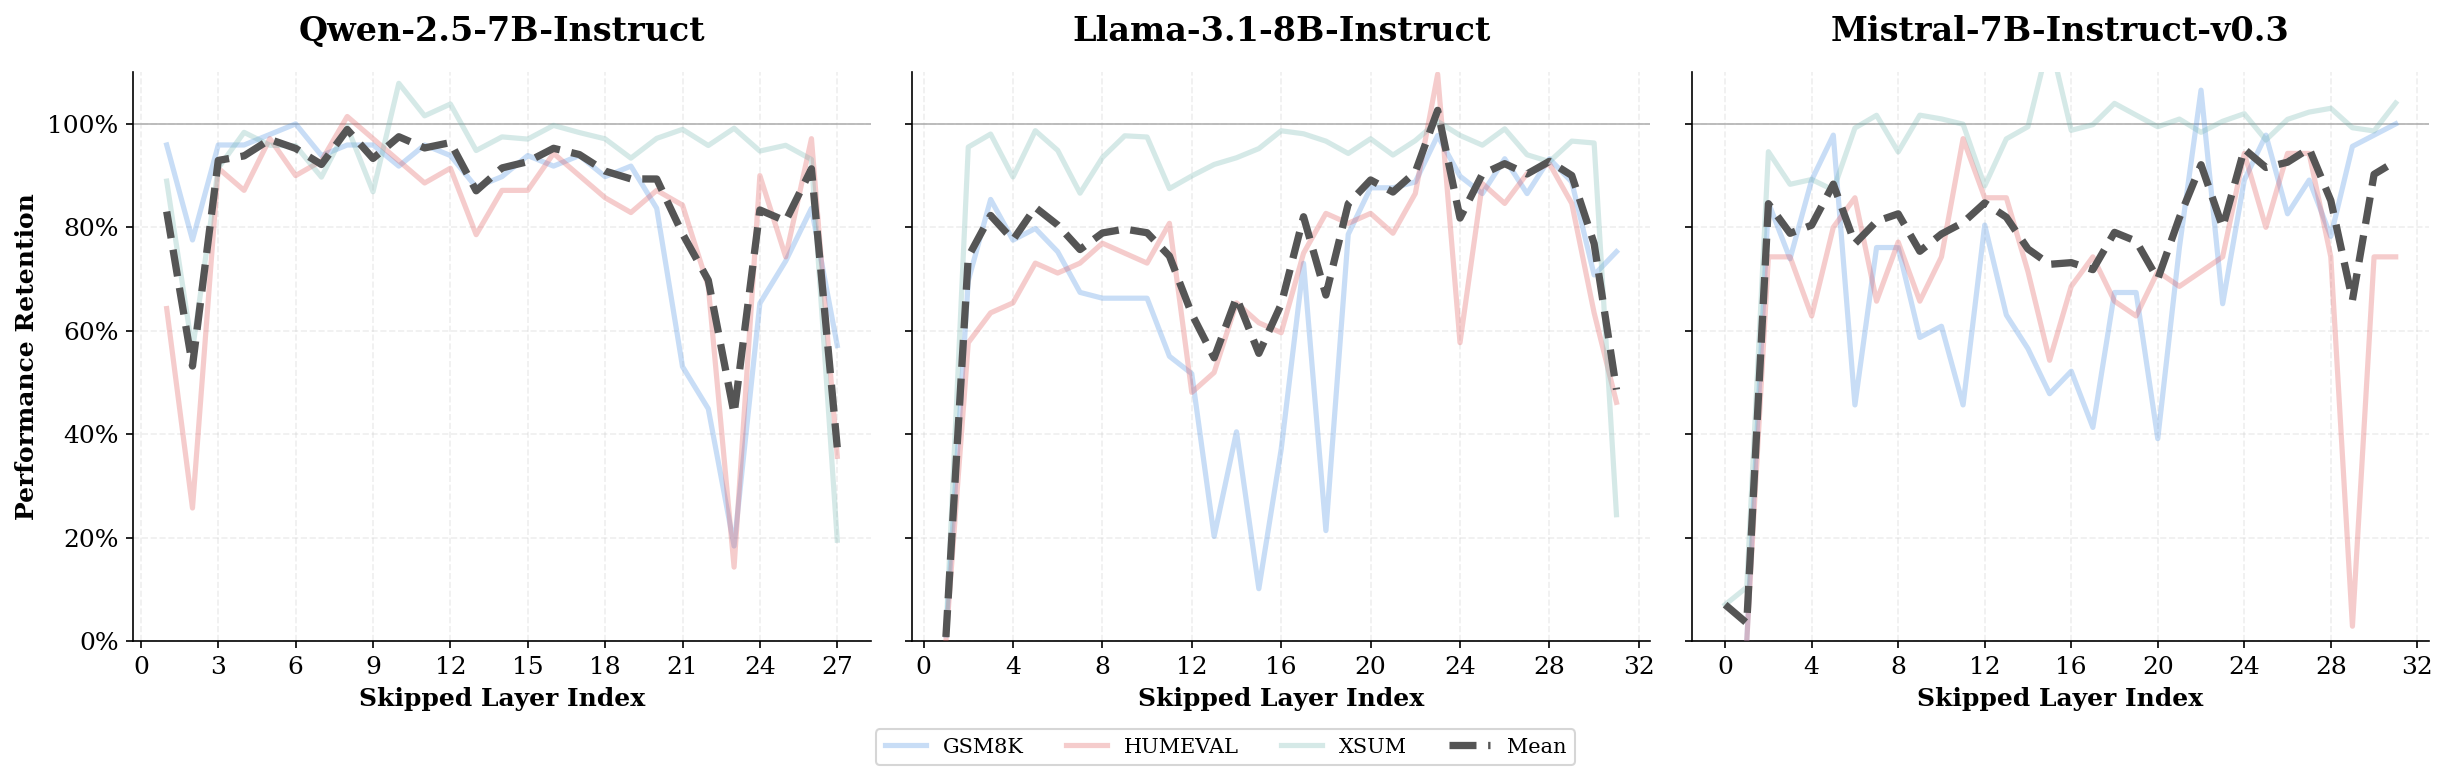

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def load_model_data(model_dirs):
    """
    Loads data for a single model across multiple dataset directories.
    Returns a list of iteration data objects similar to load_data_from_dirs in viz_multi_dataset.py.
    """
    all_iterations_data = []

    for iter_idx, dirname in enumerate(model_dirs):
        if not os.path.exists(dirname): 
            print(f"Warning: Directory {dirname} not found.")
            continue
            
        dir_basename = os.path.basename(dirname.rstrip("/"))
        inferred_ds = "unknown"
        if "__" in dir_basename:
            parts = dir_basename.split("__")
            if len(parts) > 1 and parts[1]:
                inferred_ds = parts[1]
        
        # 1. Load baseline
        baseline_path = os.path.join(dirname, "baseline.json")
        baseline_factors = {}
        if os.path.exists(baseline_path):
            with open(baseline_path, "r") as f:
                try:
                    b_data = json.load(f)
                    if "datasets" in b_data:
                        for ds_name, ds_stats in b_data["datasets"].items():
                            val = ds_stats.get("ablated_acc") or ds_stats.get("baseline_acc")
                            if val is not None: baseline_factors[ds_name] = val
                    elif "final_accuracy" in b_data:
                        baseline_factors[inferred_ds] = b_data["final_accuracy"]
                except: pass

        # 2. Find result files
        results_files = sorted(
            [f for f in os.listdir(dirname) if f.startswith("results_") and f.endswith(".json")],
            key=lambda x: int(x.strip("results_").strip(".json"))
        )
        
        layer_results = []
        available_datasets = set()
        
        for result_file in results_files:
            filepath = os.path.join(dirname, result_file)
            with open(filepath, "r") as f:
                try: 
                    data = json.load(f)
                    layer_num = data.get("layer")
                    if layer_num is None:
                        try: layer_num = int(result_file.strip("results_").strip(".json"))
                        except: continue
                    
                    normalized_scores = []
                    processed_datasets = {}
                    
                    if "datasets" in data:
                        for ds_name, ds_stats in data["datasets"].items():
                            available_datasets.add(ds_name)
                            ablated = ds_stats.get("ablated_acc", 0)
                            base = baseline_factors.get(ds_name, ds_stats.get("baseline_acc", 1.0))
                            norm = ablated / base if base > 0 else (ds_stats.get("normalized", 0))
                            processed_datasets[ds_name] = norm
                            normalized_scores.append(norm)
                    elif "final_accuracy" in data:
                        ds_name = inferred_ds
                        available_datasets.add(ds_name)
                        ablated = data["final_accuracy"]
                        base = baseline_factors.get(ds_name, 1.0)
                        norm = ablated / base if base > 0 else 1.0
                        processed_datasets[ds_name] = norm
                        normalized_scores.append(norm)
                    
                    avg_norm = sum(normalized_scores) / len(normalized_scores) if normalized_scores else 0.0
                    layer_results.append({
                        "layer": layer_num,
                        "avg_normalized": avg_norm,
                        "datasets": processed_datasets
                    })
                except: continue
        
        if layer_results:
            label = f"{list(available_datasets)[0].upper()}" if len(available_datasets) == 1 else inferred_ds.upper()
            all_iterations_data.append({
                "data": layer_results,
                "label": label,
                "datasets": sorted(list(available_datasets))
            })
            
    return all_iterations_data

def plot_multi_model_comparison(model_data_map, output_path):
    """
    Plots the performance retention for multiple models in a horizontal layout.
    Each model gets its own panel. Shared aesthetic and legend.
    """
    num_models = len(model_data_map)
    if num_models == 0: return

    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 12,
    })

    # Horizontal layout: 1 row, N columns
    fig, axes = plt.subplots(1, num_models, figsize=(5.5 * num_models, 5), dpi=150, sharey=True)
    if num_models == 1: axes = [axes]
    
    colors = ['#4A90E2', '#E15759', '#76B7B2', '#59A14F', '#EDC948', '#B07AA1']
    mean_color = '#555555'
    
    # Track labels for a shared legend
    shared_handles = {}

    for m_idx, (model_name, iterations) in enumerate(model_data_map.items()):
        ax = axes[m_idx]
        
        # Calculate Global Mean for this model
        all_layers = sorted(list(set(d["layer"] for it in iterations for d in it["data"])))
        layer_to_scores = {l: [] for l in all_layers}
        for it in iterations:
            for d in it["data"]:
                layer_to_scores[d["layer"]].append(d["avg_normalized"])
        
        mean_x, mean_y = [], []
        for l in all_layers:
            if layer_to_scores[l]:
                mean_x.append(l)
                mean_y.append(sum(layer_to_scores[l]) / len(layer_to_scores[l]))

        # Print worst performing layers for this model
        layer_scores = list(zip(mean_x, mean_y))
        sorted_by_worst = sorted(layer_scores, key=lambda x: x[1])
        worst_layers = [int(layer) for layer, score in sorted_by_worst[:10]]
        print(f"Worst performing layers for {model_name}: {worst_layers}")

        # 1. Plot Individual Benchmark averages (Solid & Faded)
        for i_idx, it_data in enumerate(iterations):
            x = [d["layer"] for d in it_data["data"]]
            y = [d["avg_normalized"] for d in it_data["data"]]
            line, = ax.plot(x, y, color=colors[i_idx % len(colors)], linestyle='-', 
                           linewidth=2.5, alpha=0.3, zorder=4)
            
            # Store handle for legend (using the benchmark label)
            if it_data["label"] not in shared_handles:
                shared_handles[it_data["label"]] = line

        # 2. Plot Model Mean (Dashed Grey)
        mean_line, = ax.plot(mean_x, mean_y, color=mean_color, linestyle='--', 
                           linewidth=3.5, zorder=10)
        if "Mean" not in shared_handles:
            shared_handles["Mean"] = mean_line

        # Aesthetics
        ax.set_title(f"{model_name}", fontsize=16, fontweight='bold', pad=15)
        
        # Only set y-label for the first plot
        if m_idx == 0:
            ax.set_ylabel("Performance Retention", fontsize=12, fontweight='bold')
            
        ax.set_xlabel("Skipped Layer Index", fontsize=12, fontweight='bold')
            
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.axhline(y=1.0, color='black', linestyle='-', linewidth=0.8, alpha=0.3, zorder=1)
        ax.grid(True, which='both', linestyle='--', alpha=0.2, zorder=1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(0, 1.1)

    # Add shared legend at the bottom
    labels = list(shared_handles.keys())
    handles = list(shared_handles.values())
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), 
               bbox_to_anchor=(0.5, -0.05), frameon=True, fontsize=10)

    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight')
    plt.savefig(output_path.replace(".pdf", ".png"), bbox_inches='tight', dpi=300)
    print(f"✓ Multi-model visualization saved to: {output_path}")

if __name__ == "__main__":
    model_to_dirs = {
        "Qwen-2.5-7B-Instruct": [
            "/scratch/ss13750/nnsight/outputs/Qwen_Qwen2_5-7B-Instruct__gsm8k____iterate",
            "/scratch/ss13750/nnsight/outputs/Qwen_Qwen2_5-7B-Instruct__humeval____iterate",
            "/scratch/ss13750/nnsight/outputs/Qwen_Qwen2_5-7B-Instruct__xsum____iterate",
        ],
        "Llama-3.1-8B-Instruct": [
            "/scratch/ss13750/nnsight/outputs/meta-llama_Llama-3_1-8B-Instruct__gsm8k____iterate",
            "/scratch/ss13750/nnsight/outputs/meta-llama_Llama-3_1-8B-Instruct__humeval____iterate",
            "/scratch/ss13750/nnsight/outputs/meta-llama_Llama-3_1-8B-Instruct__xsum____iterate",
        ],
        "Mistral-7B-Instruct-v0.3": [
            "/scratch/ss13750/nnsight/outputs/mistralai_Mistral-7B-Instruct-v0_3__gsm8k__iterate",
            "/scratch/ss13750/nnsight/outputs/mistralai_Mistral-7B-Instruct-v0_3__humeval____iterate",
            "/scratch/ss13750/nnsight/outputs/mistralai_Mistral-7B-Instruct-v0_3__xsum____iterate",
        ]
    }
    
    model_data_map = {name: load_model_data(dirs) for name, dirs in model_to_dirs.items()}
    
    viz_dir = "/scratch/ss13750/nnsight/viz"
    os.makedirs(viz_dir, exist_ok=True)
    
    plot_multi_model_comparison(model_data_map, os.path.join(viz_dir, "multi_model_ablation_comparison.pdf"))


Parsing Qwen...
Parsing Llama...
Parsing Mistral...
✓ Combined CSV saved to /scratch/ss13750/nnsight/text-degeneration-results/degeneration_comparison/combined_degeneration_results.csv
✓ Visualization saved to /scratch/ss13750/nnsight/text-degeneration-results/degeneration_comparison/model_comparison_text_degeneration.pdf
✓ Avg Tokens plot saved to /scratch/ss13750/nnsight/text-degeneration-results/degeneration_comparison/avg_tokens_degeneration.pdf


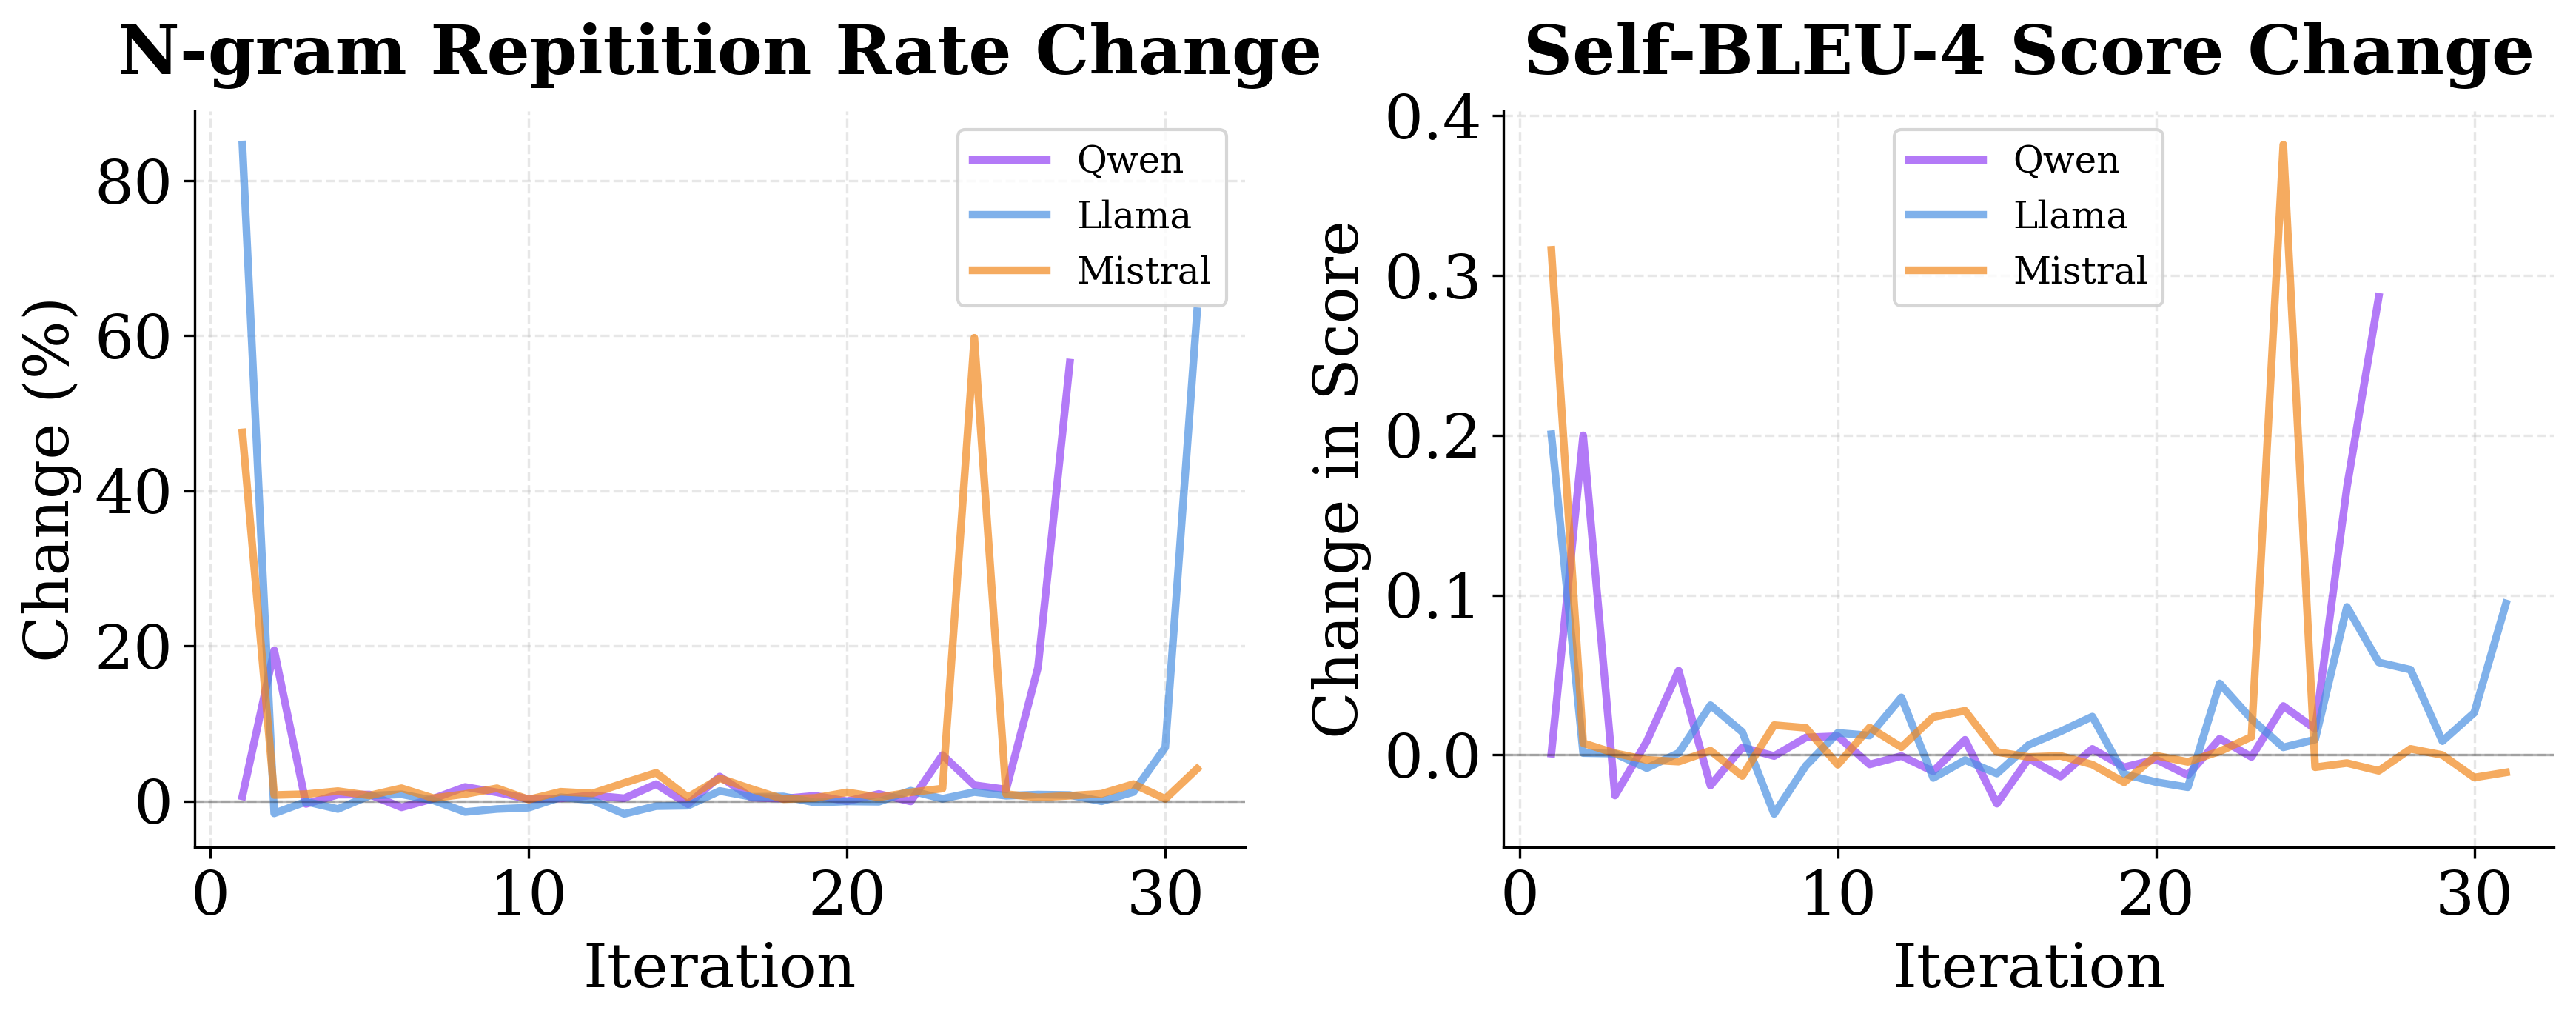

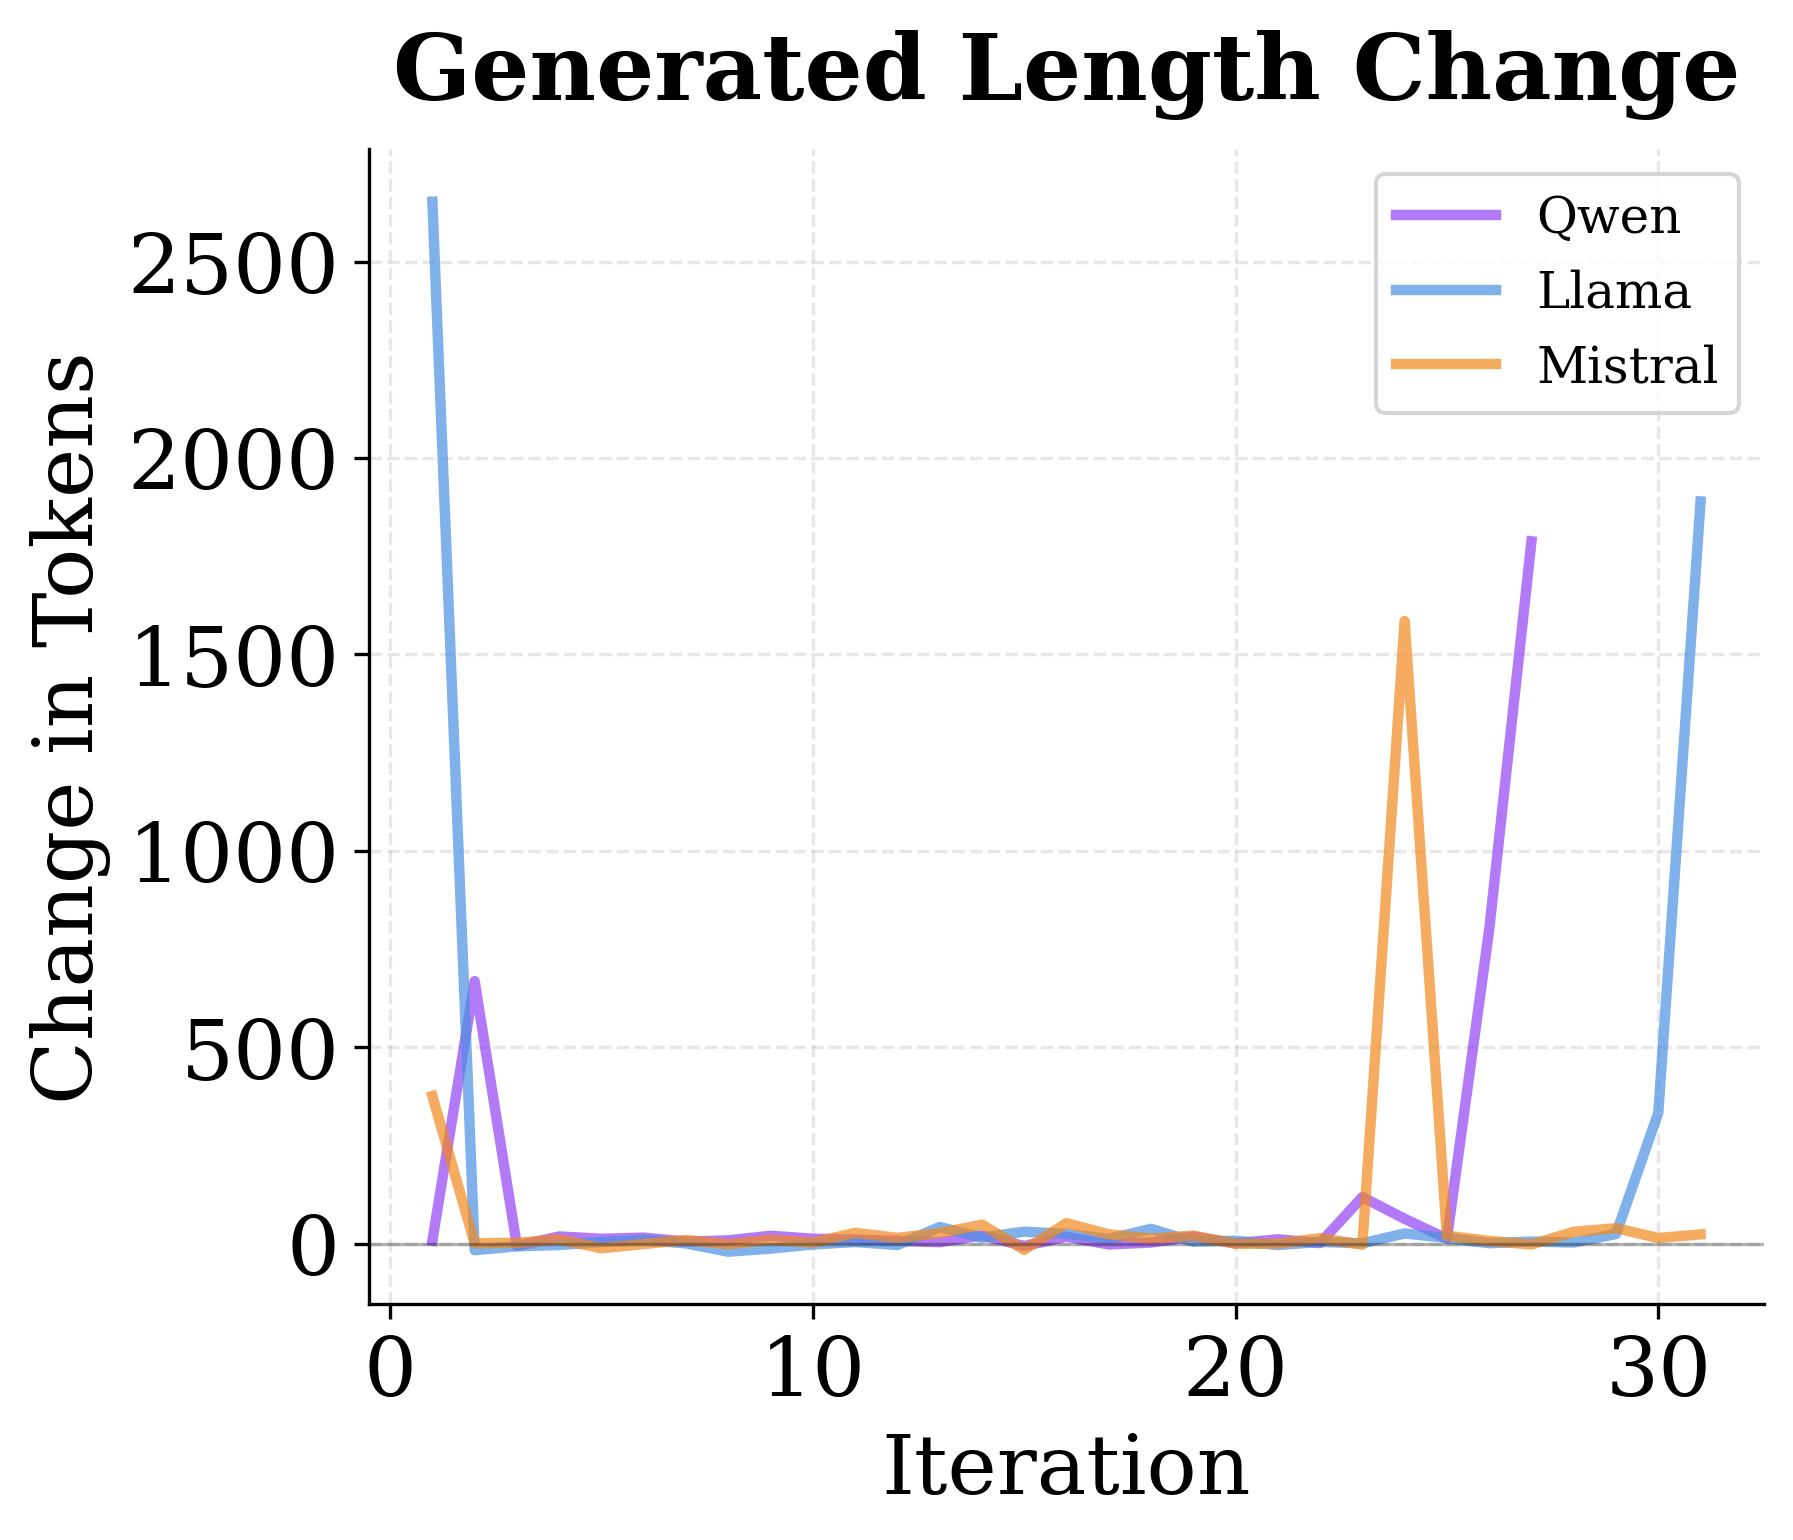

In [6]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import seaborn as sns

# --- Configuration & Styling ---
def apply_publication_style():
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 20,
        "axes.labelsize": 20,
        "axes.titlesize": 22,
        "legend.fontsize": 16,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "grid.linestyle": "--",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "lines.linewidth": 2.5,
        "lines.markersize": 7,
    })

def parse_degeneration_file(filepath, model_name):
    """
    Parses the text degeneration output file and returns a pandas DataFrame.
    """
    data_list = []
    
    current_iteration = None
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        line = line.strip()
        
        # Detect file processing line to get iteration
        if line.startswith("Processing"):
            match = re.search(r"results_(\d+)\.json", line)
            if match:
                current_iteration = int(match.group(1))
            elif "baseline.json" in line:
                current_iteration = 0 # Treat baseline as iteration 0
            else:
                current_iteration = None
            continue
            
        # Parse data lines
        if "|" in line and not line.startswith("Dataset") and not line.startswith("="):
            parts = [p.strip() for p in line.split("|")]
            if len(parts) >= 7:
                dataset = parts[0]
                try:
                    avg_tokens = float(parts[2])
                    rep2 = float(parts[3].strip('%'))
                    rep3 = float(parts[4].strip('%'))
                    rep4 = float(parts[5].strip('%'))
                    intra_bleu = float(parts[6])
                    
                    if current_iteration is not None:
                        data_list.append({
                            "Model": model_name,
                            "Iteration": current_iteration,
                            "Dataset": dataset,
                            "Avg Tokens": avg_tokens,
                            "Rep-2": rep2,
                            "Rep-3": rep3,
                            "Rep-4": rep4,
                            "Intra-BLEU-4": intra_bleu
                        })
                except ValueError:
                    continue

    df = pd.DataFrame(data_list)
    return df.sort_values(by=["Model", "Dataset", "Iteration"])

def plot_degeneration_metrics(df, save_dir):
    """
    Plots degeneration metrics averaged across datasets, relative to the baseline.
    Compares multiple models.
    Horizontal layout: [Repetition Rates] | [Intra-BLEU-4] | [Avg Tokens]
    """
    apply_publication_style()
    
    metrics_group1 = ["Rep-2", "Rep-3", "Rep-4"]
    metric_bleu = "Intra-BLEU-4"
    metric_tokens = "Avg Tokens"
    all_metrics = metrics_group1 + [metric_bleu, metric_tokens]
    
    # 1. Calculate Relative Change per Model & Dataset
    df_relative = df.copy()
    models = df["Model"].unique()
    datasets = df["Dataset"].unique()
    
    for model in models:
        for ds in datasets:
            # Get baseline for this specific model and dataset
            baseline_row = df[(df["Model"] == model) & (df["Dataset"] == ds) & (df["Iteration"] == 0)]
            if not baseline_row.empty:
                for metric in all_metrics:
                    base_val = baseline_row[metric].values[0]
                    # Calc delta
                    mask = (df["Model"] == model) & (df["Dataset"] == ds)
                    df_relative.loc[mask, metric] = df.loc[mask, metric] - base_val
            else:
                # Some models might not have all datasets or baseline info
                pass

    # 2. Aggregate across datasets (Mean) per Model & Iteration
    df_agg = df_relative.groupby(["Model", "Iteration"])[all_metrics].mean().reset_index()
    
    # Filter out baseline (Iteration 0) from the plot
    df_agg = df_agg[df_agg["Iteration"] > 0]

    # 3. Create Plots (Repetition & BLEU)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
    
    # Define model styles
    # Colors: Llama (Blue), Qwen (Purple)
    model_colors = {
        'Qwen': '#9342f5', 
        'Llama': '#4A90E2',
        'Mistral': '#f2881d'
    }
    
    # Plotting Helper
    def plot_metric_on_ax(ax, metric_col, title, ylabel, is_rep_group=False):
        for idx, model in enumerate(models):
            subset = df_agg[df_agg["Model"] == model]
            color = model_colors.get(model, f'C{idx}')
            
            if is_rep_group:
                # Calculate mean of Rep-2, Rep-3, Rep-4 rows
                y_vals = subset[metrics_group1].mean(axis=1)
                label = model
            else:
                y_vals = subset[metric_col]
                label = model
            
            ax.plot(subset["Iteration"], y_vals, label=label, 
                    color=color, linewidth=2.5, alpha=0.7)

        ax.set_title(title, fontweight='bold', pad=12)
        ax.set_ylabel(ylabel)
        ax.set_xlabel("Iteration")
        ax.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.legend(frameon=True, fontsize=12)

    # --- Plot 1: Repetition Rates (Avg of 2,3,4) ---
    plot_metric_on_ax(axes[0], None, "N-gram Repitition Rate Change", "Change (%)", is_rep_group=True)
    
    # --- Plot 2: Intra-BLEU-4 ---
    plot_metric_on_ax(axes[1], metric_bleu, "Self-BLEU-4 Score Change", "Change in Score")

#     plt.suptitle("Degeneration Metrics Relative to Baseline (Model Comparison)", 
#                  fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    
    save_path = os.path.join(save_dir, "model_comparison_text_degeneration.pdf")
    plt.savefig(save_path, bbox_inches='tight')
    plt.savefig(save_path.replace(".pdf", ".png"), bbox_inches='tight', dpi=300)
    print(f"✓ Visualization saved to {save_path}")
    
    # 4. Separate Plot: Avg Tokens
    plt.figure(figsize=(6, 5), dpi=300)
    ax_tokens = plt.gca()
    plot_metric_on_ax(ax_tokens, metric_tokens, "Generated Length Change", "Change in Tokens")
    
    tokens_path = os.path.join(save_dir, "avg_tokens_degeneration.pdf")
    plt.savefig(tokens_path, bbox_inches='tight')
    plt.savefig(tokens_path.replace(".pdf", ".png"), bbox_inches='tight', dpi=300)
    print(f"✓ Avg Tokens plot saved to {tokens_path}")

if __name__ == "__main__":
    # Define models and their log files
    model_files = {
        "Qwen": "/scratch/ss13750/nnsight/text-degeneration-results/qwen_iterate_self_bleu.out",
        "Llama": "/scratch/ss13750/nnsight/text-degeneration-results/llama_iterate_self_bleu.out",
        "Mistral": "/scratch/ss13750/nnsight/text-degeneration-results/mistral_self_bleu.out"
    }
    
    # Common Output Directory
    base_dir = "/scratch/ss13750/nnsight/text-degeneration-results"
    output_dir = os.path.join(base_dir, "degeneration_comparison")
    os.makedirs(output_dir, exist_ok=True)
    
    dfs = []
    
    for model_name, filepath in model_files.items():
        if not os.path.exists(filepath):
            print(f"Warning: File for {model_name} not found at {filepath}")
            continue
            
        print(f"Parsing {model_name}...")
        df_model = parse_degeneration_file(filepath, model_name)
        dfs.append(df_model)
    
    if not dfs:
        print("No data parsed.")
        exit(1)
        
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Save Combined CSV
    csv_path = os.path.join(output_dir, "combined_degeneration_results.csv")
    combined_df.to_csv(csv_path, index=False)
    print(f"✓ Combined CSV saved to {csv_path}")
    
    # Plot
    plot_degeneration_metrics(combined_df, output_dir)


In [43]:
# dirname = "/scratch/ss13750/nnsight/outputs/Qwen_Qwen2_5-7B-Instruct__gsm8k____iterate"
# dirname = "/scratch/ss13750/nnsight/outputs/meta-llama_Llama-3_1-8B-Instruct__gsm8k____iterate"
# dirname = "/scratch/ss13750/nnsight/outputs/meta-llama_Llama-3_1-8B-Instruct__gsm8k_multi____iterate"
# dirname = "/scratch/ss13750/nnsight/outputs/Qwen_Qwen2_5-7B-Instruct__gsm8k_multi____iterate"
dirname = "/scratch/ss13750/nnsight/outputs/mistralai_Mistral-7B-Instruct-v0_3__gsm8k_multi____iterate"

files = os.listdir(dirname)

In [44]:
all_acc = []
datas = []

for file in files:
    if "baseline" in file: continue

    layer = int(file.split("_")[1].replace(".json", ""))
    with open(f"{dirname}/{file}", "r") as f:
        data = json.load(f)
        datas.append(data)
#         all_acc.append((layer, data['final_accuracy']))

In [45]:
data['layer']

22

In [47]:
msgs

{24: ["failed: unsupported operand type(s) for -: 'str' and 'int'",
  'failed: list index out of range',
  'failed: invalid syntax (<string>, line 31)',
  "failed: invalid literal for int() with base 10: '-'",
  'timed out',
  'timed out',
  "failed: name 'log' is not defined",
  'failed: maximum recursion depth exceeded in comparison',
  "failed: 'filter' object has no attribute 'lstrip'",
  'failed: invalid syntax (<string>, line 19)',
  "failed: unsupported operand type(s) for %: 'complex' and 'int'",
  'failed: invalid syntax (<string>, line 15)',
  'failed: invalid syntax (<string>, line 15)',
  'failed: invalid syntax. Perhaps you forgot a comma? (<string>, line 13)',
  "failed: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U1'), dtype('float64')) -> None",
  "failed: name 'filename' is not defined"],
 15: ['timed out',
  'timed out',
  'failed: not enough values to unpack (expected 3, got 1)',
  "failed: local variable 'sum' referenced before ass


Generation for: Percentage of Total Samples
Found 31 result files in /scratch/ss13750/nnsight/outputs/mistralai_Mistral-7B-Instruct-v0_3__gsm8k_multi____iterate...
Loaded baseline from /scratch/ss13750/nnsight/outputs/mistralai_Mistral-7B-Instruct-v0_3__gsm8k_multi____iterate/baseline.json

--- Baseline Statistics ---
Total Samples: 100
Percentage of Total Samples:
  Passed: 31.00% (31)
  Others: 9.00% (9)
  Assertion Error: 54.00% (54)
  Timeout: 2.00% (2)
  Not Defined: 2.00% (2)
  Bracket/Syntax: 1.00% (1)
  Other Syntax: 1.00% (1)
Proportion of Errors (Total Errors: 69):
  Others: 13.04% (9)
  Assertion Error: 78.26% (54)
  Timeout: 2.90% (2)
  Not Defined: 2.90% (2)
  Bracket/Syntax: 1.45% (1)
  Other Syntax: 1.45% (1)
---------------------------

✓ Plots saved to /scratch/ss13750/nnsight/degeneration_comparison/coding_error_percentages.png
✓ Data saved to /scratch/ss13750/nnsight/degeneration_comparison/coding_error_percentages.csv

Generation for: Proportion of Errors
Found 31 

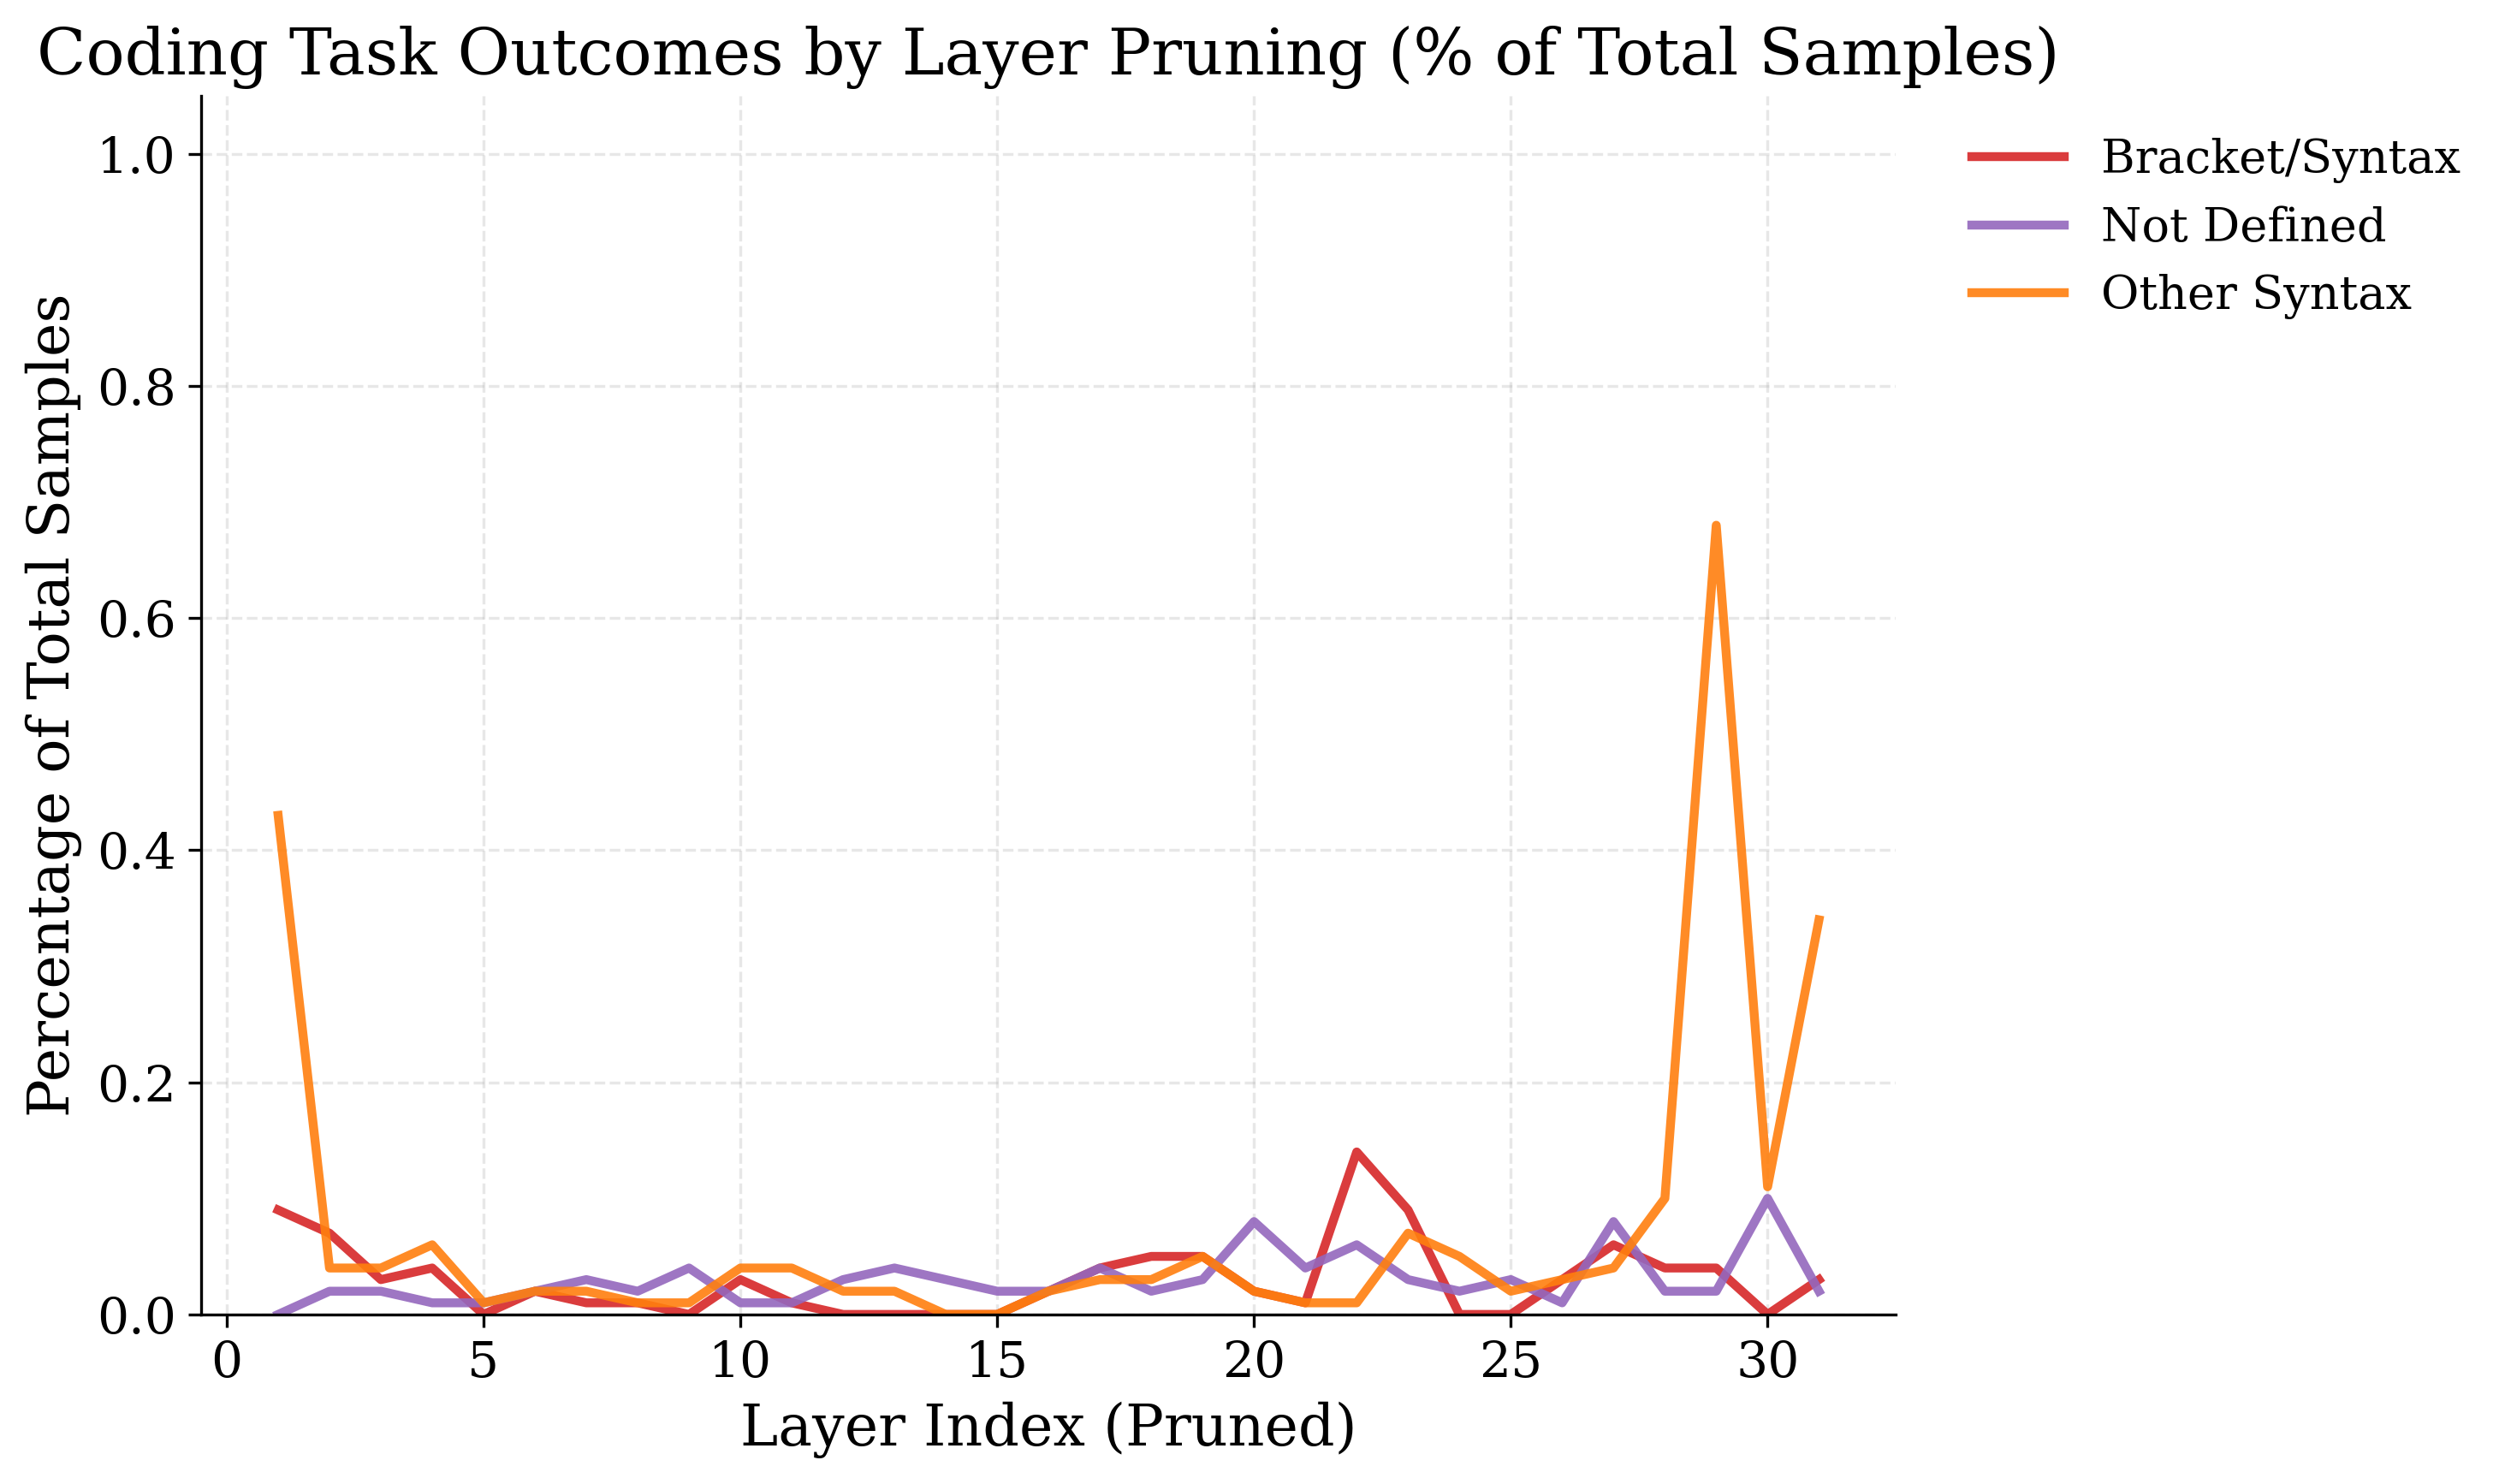

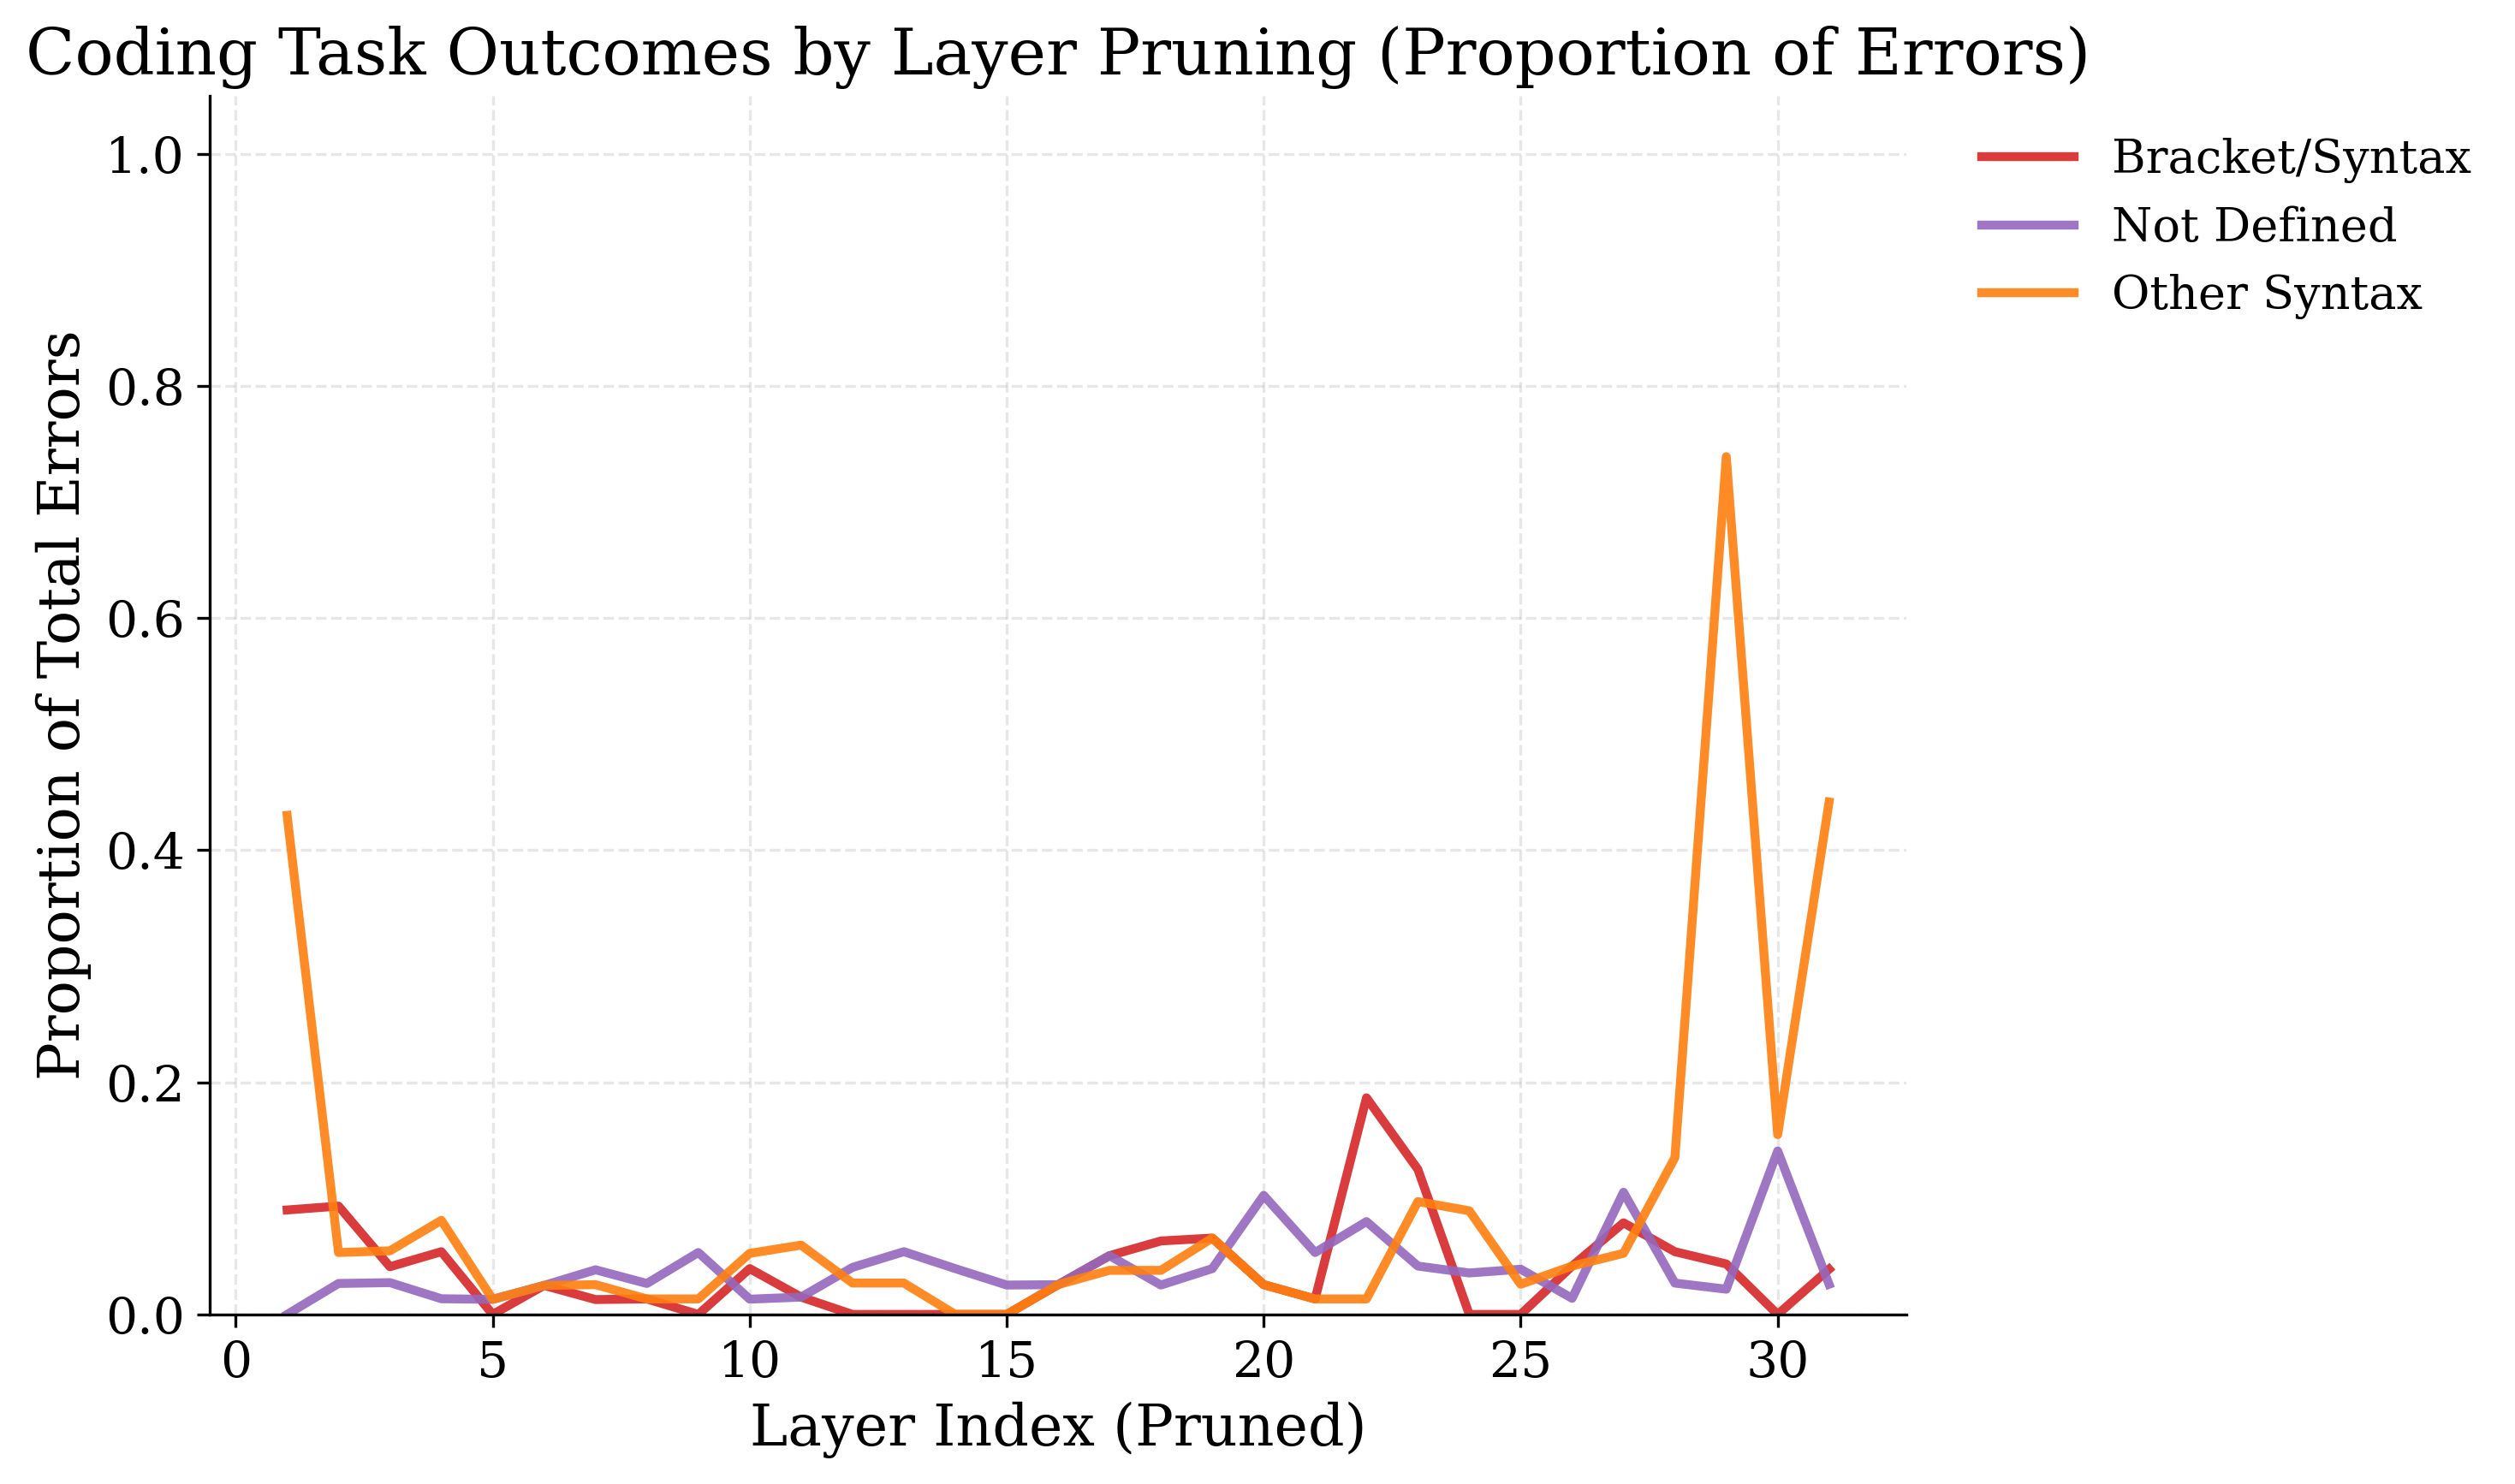

In [67]:
import json
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Style configurations for publication-quality plots
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "legend.fontsize": 13,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "lines.linewidth": 2.5,
    "lines.markersize": 0,
})

# dirname = "/scratch/ss13750/nnsight/outputs/meta-llama_Llama-3_1-8B-Instruct__gsm8k_multi____iterate"
# dirname = "/scratch/ss13750/nnsight/outputs/Qwen_Qwen2_5-7B-Instruct__gsm8k_multi____iterate"
dirname = "/scratch/ss13750/nnsight/outputs/mistralai_Mistral-7B-Instruct-v0_3__gsm8k_multi____iterate"
save_dir = "/scratch/ss13750/nnsight/degeneration_comparison"
os.makedirs(save_dir, exist_ok=True)

# Configuration: Set to True for proportion of errors, False for percentage of total samples
USE_PROPORTION_OF_ERRORS = False  # Change this to toggle mode

def get_category(msg, bracket_keywords):
    if msg == "passed":
        return "Passed"
    if msg == "failed: ":
        return "Assertion Error"
    if any(s in msg for s in bracket_keywords):
        return "Bracket/Syntax"
    if "invalid syntax" in msg:
        return "Other Syntax"
    if "is not defined" in msg: 
        return "Not Defined"
    if "timed out" in msg or "depth exceeded" in msg:
         return "Timeout"
    return "Others"

def process_baseline(dirname, bracket_keywords):
    # Try to find baseline file
    baseline_files = [os.path.join(dirname, "baseline.json"), os.path.join(dirname, "results_0.json")]
    baseline_data = None
    
    for fpath in baseline_files:
        if os.path.exists(fpath):
            try:
                with open(fpath, "r") as f:
                    baseline_data = json.load(f)
                print(f"Loaded baseline from {fpath}")
                break
            except Exception as e:
                print(f"Error loading {fpath}: {e}")
    
    if not baseline_data:
        print("No baseline file found.")
        return

    if 'datasets' not in baseline_data or 'humeval' not in baseline_data['datasets'] or 'items' not in baseline_data['datasets']['humeval']:
        print("Baseline file does not contain humeval items.")
        return

    items = baseline_data['datasets']['humeval']['items']
    total_samples = len(items)
    counts = {}
    
    for item in items:
        msg = item.get('result', '')
        cat = get_category(msg, bracket_keywords)
        counts[cat] = counts.get(cat, 0) + 1
        
    print("\n--- Baseline Statistics ---")
    print(f"Total Samples: {total_samples}")
    
    # Calculate percentages of total samples
    print("Percentage of Total Samples:")
    for cat, count in counts.items():
        pct = (count / total_samples) * 100
        print(f"  {cat}: {pct:.2f}% ({count})")
        
    # Calculate proportion of errors (excluding passed)
    total_errors = total_samples - counts.get("Passed", 0)
    if total_errors > 0:
        print(f"Proportion of Errors (Total Errors: {total_errors}):")
        for cat, count in counts.items():
            if cat == "Passed": continue
            prop = (count / total_errors) * 100
            print(f"  {cat}: {prop:.2f}% ({count})")
    else:
        print("No errors in baseline.")
    print("---------------------------\n")


def main():
    datas = []
    
    # Locate all result files and load them
    search_pattern = os.path.join(dirname, "results_*.json")
    files = glob.glob(search_pattern)
    
    print(f"Found {len(files)} result files in {dirname}...")

    # Updated bracket error keywords
    bracket_keywords = [
        "was never closed", 
        "opening parenthesis", 
        "unmatched ')'", 
        "unmatched '}'", 
        "unmatched ']'"
    ]
    
    # Process baseline first
    process_baseline(dirname, bracket_keywords)

    for file_path in files:
        filename = os.path.basename(file_path)
        match = re.search(r"results_(\d+)\.json", filename)
        if not match:
            continue
            
        layer = int(match.group(1))
        
        if layer == 0:
            continue

        try:
            with open(file_path, "r") as f:
                content = json.load(f)
                content['layer'] = layer
                datas.append(content)
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    records = []
    
    for data in datas:
        layer = data['layer']
        
        if 'datasets' not in data or 'humeval' not in data['datasets'] or 'items' not in data['datasets']['humeval']:
            continue

        items = data['datasets']['humeval']['items']
        # total_samples_in_layer = len(items) # Unused variable removed

        for item in items:
            msg = item.get('result', '')
            
            category = get_category(msg, bracket_keywords)
            
            if USE_PROPORTION_OF_ERRORS and category == "Passed":
                continue
            
            records.append({
                "Layer": layer,
                "Category": category
            })

    if not records:
        print("No records found.")
        return

    df = pd.DataFrame(records)
    
    # Count occurrences of each category per layer
    df_counts = df.groupby(['Layer', 'Category']).size().reset_index(name='Count')
    
    if USE_PROPORTION_OF_ERRORS:
        # Denominator is total errors in that layer
        total_per_layer = df_counts.groupby('Layer')['Count'].transform('sum')
        y_label = "Proportion of Total Errors"
        plot_filename = "coding_error_proportions"
        title_suffix = "(Proportion of Errors)"
    else:
        # Denominator is total samples in that layer (sum of all categories including passed)
        total_per_layer = df_counts.groupby('Layer')['Count'].transform('sum')
        y_label = "Percentage of Total Samples"
        plot_filename = "coding_error_percentages"
        title_suffix = "(% of Total Samples)"
        
    df_counts['Value'] = df_counts['Count'] / total_per_layer

    # Pivot for plotting
    df_pivot = df_counts.pivot(index='Layer', columns='Category', values='Value').fillna(0)
    df_pivot = df_pivot.sort_index()

    # Define colors
    category_colors = {
        "Passed": "#2ca02c",             # Green
        "Assertion Error": "#1f77b4",    # Blue
        "Bracket/Syntax": "#d62728",     # Red
        "Other Syntax": "#ff7f0e",       # Orange
        "Not Defined": "#9467bd",        # Purple
        "Timeout": "#8c564b",            # Brown
        "Others": "#7f7f7f"              # Gray
    }

    # Plot
    plt.figure(figsize=(10, 6), dpi=300)
    
    for cat in df_pivot.columns:
        
        
        if cat in ["Others", "Timeout", "Assertion Error", "Passed"]: continue
            
            
            
        color = category_colors.get(cat, None)
        plt.plot(df_pivot.index, df_pivot[cat], label=cat, color=color, alpha=0.9)

    plt.title(f"Coding Task Outcomes by Layer Pruning {title_suffix}")
    plt.xlabel("Layer Index (Pruned)")
    plt.ylabel(y_label)
    plt.ylim(0, 1.05)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
    plt.tight_layout()

    # Save
    plot_path = os.path.join(save_dir, f"{plot_filename}.png")
    pdf_path = os.path.join(save_dir, f"{plot_filename}.pdf")
    csv_path = os.path.join(save_dir, f"{plot_filename}.csv")

    plt.savefig(plot_path)
    plt.savefig(pdf_path)
    print(f"✓ Plots saved to {plot_path}")
    
    df_pivot.to_csv(csv_path)
    print(f"✓ Data saved to {csv_path}")

if __name__ == "__main__":
    # Generate both versions
    
    # 1. Percentage of Total Samples
    print("\nGeneration for: Percentage of Total Samples")
    USE_PROPORTION_OF_ERRORS = False
    main()
    
    # 2. Proportion of Errors
    print("\nGeneration for: Proportion of Errors")
    USE_PROPORTION_OF_ERRORS = True
    main()

✓ Publication-ready plot saved to: /scratch/ss13750/nnsight/viz/coding_degeneration_prop.pdf


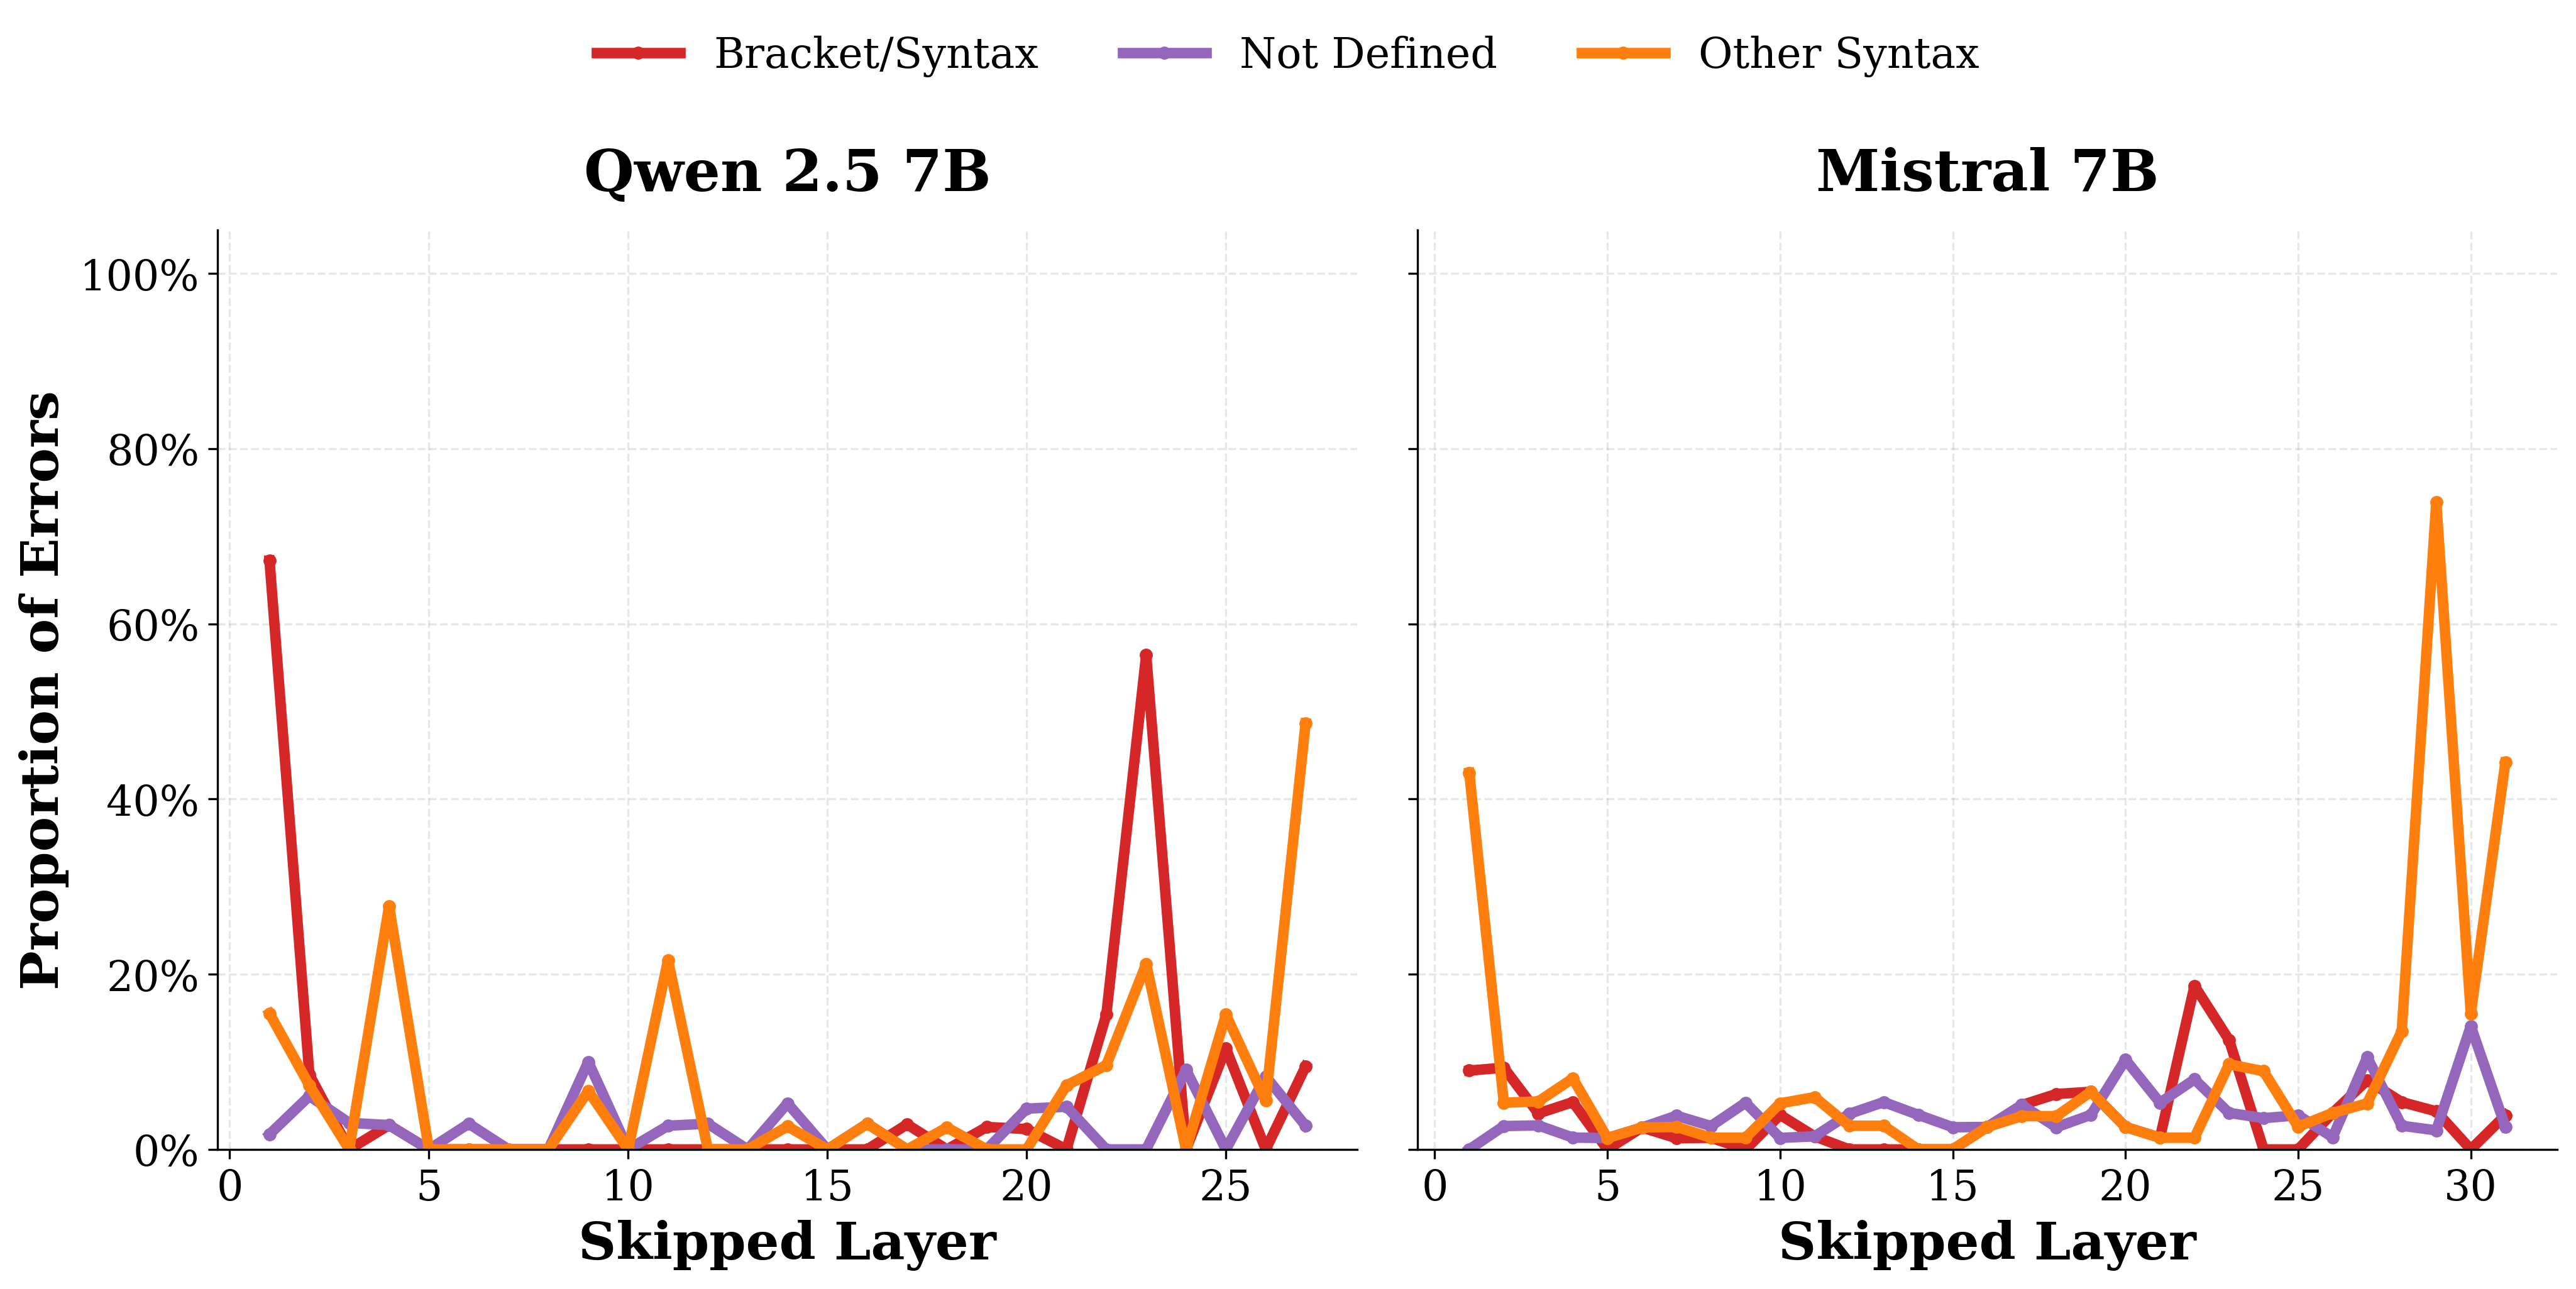

In [1]:
import json
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import glob

# --- GLOBAL STYLING FOR SINGLE-COLUMN PUBLICATION ---
# We use a smaller figsize but keep the font sizes large. 
# This makes the labels much larger relative to the plot area.
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 18,             # Overall base
    "axes.titlesize": 22,        # Model Names
    "axes.labelsize": 20,        # X and Y labels
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 15,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "lines.linewidth": 4,        # Much thicker lines for small figures
    "figure.dpi": 300,
    "figure.titlesize": 24
})

# Directories to compare
dir1 = "/scratch/ss13750/nnsight/outputs/Qwen_Qwen2_5-7B-Instruct__gsm8k_multi____iterate"
dir2 = "/scratch/ss13750/nnsight/outputs/mistralai_Mistral-7B-Instruct-v0_3__gsm8k_multi____iterate"

# Configuration
USE_PROPORTION_OF_ERRORS = True
SKIP_CATEGORIES = ["Others", "Timeout", "Assertion Error", "Passed"]

def get_category(msg, bracket_keywords):
    if msg == "passed": return "Passed"
    if msg == "failed: ": return "Assertion Error"
    if any(s in msg for s in bracket_keywords): return "Bracket/Syntax"
    if "invalid syntax" in msg: return "Other Syntax"
    if "is not defined" in msg: return "Not Defined"
    if "timed out" in msg or "depth exceeded" in msg: return "Timeout"
    return "Others"

def process_directory(dirname, bracket_keywords):
    datas = []
    files = glob.glob(os.path.join(dirname, "results_*.json"))
    for file_path in files:
        match = re.search(r"results_(\d+)\.json", os.path.basename(file_path))
        if not match: continue
        layer = int(match.group(1))
        if layer == 0: continue
        with open(file_path, "r") as f:
            try:
                content = json.load(f)
                content['layer'] = layer
                datas.append(content)
            except: continue

    records = []
    for data in datas:
        if 'datasets' not in data or 'humeval' not in data['datasets']: continue
        items = data['datasets']['humeval'].get('items', [])
        for item in items:
            msg = item.get('result', '')
            category = get_category(msg, bracket_keywords)
            if USE_PROPORTION_OF_ERRORS and category == "Passed": continue
            records.append({"Layer": data['layer'], "Category": category})
            
    if not records: return pd.DataFrame()
    df = pd.DataFrame(records)
    df_counts = df.groupby(['Layer', 'Category']).size().reset_index(name='Count')
    total_per_layer = df_counts.groupby('Layer')['Count'].transform('sum')
    df_counts['Value'] = df_counts['Count'] / total_per_layer
    return df_counts.pivot(index='Layer', columns='Category', values='Value').fillna(0).sort_index()

def main():
    bracket_keywords = ["was never closed", "opening parenthesis", "unmatched ')'", "unmatched '}'", "unmatched ']'"]
    df1 = process_directory(dir1, bracket_keywords)
    df2 = process_directory(dir2, bracket_keywords)

    category_colors = {
        "Bracket/Syntax": "#d62728", # Red
        "Other Syntax": "#ff7f0e",   # Orange
        "Not Defined": "#9467bd",     # Purple
        "Others": "#7f7f7f"          # Gray
    }

    # Figure size adjusted for 2-subplot scaling. 
    # (14, 6) is wide, but fonts are large enough to survive shrink.
    fig, axes = plt.subplots(1, 2, figsize=(14, 6.5), sharey=True)
    
    def plot_df(ax, df, title):
        if df.empty: return
        for cat in df.columns:
            if cat in SKIP_CATEGORIES: continue
            ax.plot(df.index, df[cat], label=cat, color=category_colors.get(cat), marker='o', markersize=4)
        
        ax.set_title(title, fontweight='bold', pad=15)
        ax.set_xlabel("Skipped Layer", fontweight='bold')
        ax.set_ylim(0, 1.05)
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

    # Helper to clean model names
    def clean_name(path):
        name = os.path.basename(path.rstrip('/'))
        if 'Qwen' in name: return "Qwen 2.5 7B"
        if 'Mistral' in name: return "Mistral 7B"
        if 'Llama' in name: return "Llama 3.1 8B"
        return name

    plot_df(axes[0], df1, clean_name(dir1))
    plot_df(axes[1], df2, clean_name(dir2))

    axes[0].set_ylabel("Proportion of Errors" if USE_PROPORTION_OF_ERRORS else "Percentage of Total", fontweight='bold')

    # Legend placement: Above the plots, very clean
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), 
               ncol=len(labels), frameon=False, fontsize=16)

    plt.tight_layout()
    
    # Save
    save_dir = "/scratch/ss13750/nnsight/viz"
    os.makedirs(save_dir, exist_ok=True)
    suffix = "prop" if USE_PROPORTION_OF_ERRORS else "total"
    pdf_path = os.path.join(save_dir, f"coding_degeneration_{suffix}.pdf")
    
    plt.savefig(pdf_path, bbox_inches='tight')
    plt.savefig(pdf_path.replace(".pdf", ".png"), bbox_inches='tight')
    print(f"✓ Publication-ready plot saved to: {pdf_path}")

if __name__ == "__main__":
    main()

✓ Compact visualization saved to /scratch/ss13750/nnsight/viz/compact_comparison.pdf


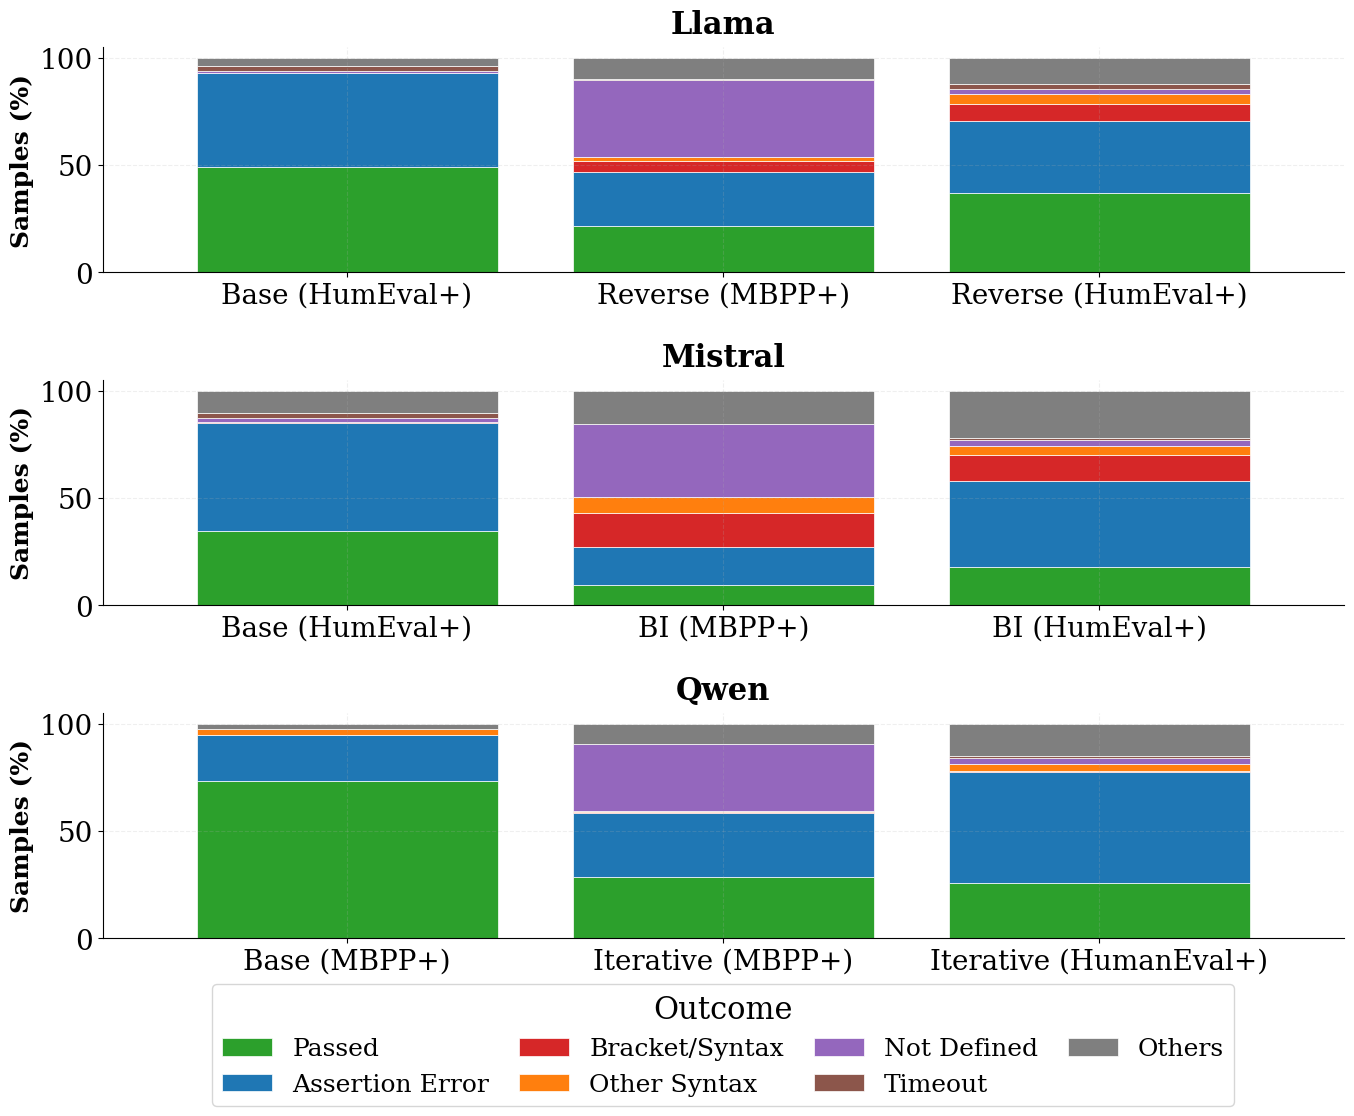

In [29]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. DATA STRUCTURE ---
model_groups = [
    {
        "family": "Llama",
        "results": {
            "Base (HumEval+)": "/scratch/ss13750/nnsight/outputs/meta-llama_Llama-3_1-8B-Instruct__gsm8k_multi____iterate/baseline.json",
            "Reverse (MBPP+)": "/scratch/ss13750/nnsight/eval_results/8cossim_lora_self_dolci_llama_checkpoint-11250_mbpp_LLAMA_MBPP_PROMPT_eval.json",
            "Reverse (HumEval+)": "/scratch/ss13750/nnsight/eval_results/8cossim_lora_self_dolci_llama_checkpoint-11250_humeval_LLAMA_HUMEVAL_PROMPT_eval.json",
        }
    },
    {
        "family": "Mistral",
        "results": {
            "Base (HumEval+)": "/scratch/ss13750/nnsight/eval_results/mistralai_Mistral-7B-Instruct-v0.3_humeval_MISTRAL_HUMEVAL_eval.json",
            "BI (MBPP+)": "/scratch/ss13750/nnsight/eval_results/8cossim_lora_self_dolci_mistral_checkpoint-11250_mbpp_MISTRAL_MBPP_eval.json",
            "BI (HumEval+)": "/scratch/ss13750/nnsight/eval_results/8cossim_lora_self_dolci_mistral_checkpoint-11250_humeval_MISTRAL_HUMEVAL_eval.json",
        }
    },
    {
        "family": "Qwen",
        "results": {
            "Base (MBPP+)": "/scratch/ss13750/nnsight/eval_results/Qwen_Qwen2.5-7B-Instruct_humeval_QWEN_HUMEVAL_PROMPT_eval.json",
            "Iterative (MBPP+)": "/scratch/ss13750/nnsight/eval_results/new7iter_lora_self_dolci_qwen_checkpoint-11250_mbpp_QWEN_MBPP_PROMPT_eval.json",
            "Iterative (HumanEval+)": "/scratch/ss13750/nnsight/eval_results/new7iter_lora_self_dolci_qwen_checkpoint-11250_humeval_QWEN_HUMEVAL_PROMPT_eval.json"
        }
    },
    
#     {
#         "family": "Llama",
#         "results": {
#             "Base (HumEval+)": "/scratch/ss13750/nnsight/outputs/meta-llama_Llama-3_1-8B-Instruct__gsm8k_multi____iterate/baseline.json",
#             "Reverse (MBPP+)": "/scratch/ss13750/nnsight/eval_results/8cossim_lora_dolci_llama_checkpoint-11250_mbpp_LLAMA_MBPP_PROMPT_eval.json",
#             "Reverse (HumEval+)": "/scratch/ss13750/nnsight/eval_results/8cossim_lora_dolci_llama_checkpoint-11250_humeval_LLAMA_HUMEVAL_PROMPT_eval.json",
#         }
#     },
#     {
#         "family": "Qwen",
#         "results": {
#             "Base (MBPP+)": "/scratch/ss13750/nnsight/outputs/meta-llama_Llama-3_1-8B-Instruct__gsm8k_multi____iterate/baseline.json",
#             "BI (MBPP+)": "/scratch/ss13750/nnsight/eval_results/new8iter_lora_self_dolci_llama_checkpoint-11250_mbpp_LLAMA_MBPP_PROMPT_eval.json",
#             "BI (HumanEval+)": "/scratch/ss13750/nnsight/eval_results/new8iter_lora_self_dolci_llama_checkpoint-11250_humeval_LLAMA_HUMEVAL_PROMPT_eval.json"
#         }
#     },
#     {
#         "family": "Qwen",
#         "results": {
#             "Base (MBPP+)": "/scratch/ss13750/nnsight/outputs/meta-llama_Llama-3_1-8B-Instruct__gsm8k_multi____iterate/baseline.json",
#             "BI (MBPP+)": "/scratch/ss13750/nnsight/eval_results/new8iter_lora_self_dolci_llama_checkpoint-11250_mbpp_LLAMA_MBPP_PROMPT_eval.json",
#             "BI (HumanEval+)": "/scratch/ss13750/nnsight/eval_results/new8iter_lora_self_dolci_llama_checkpoint-11250_humeval_LLAMA_HUMEVAL_PROMPT_eval.json"
#         }
#     }    
]

# --- Professional Styling ---
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 22,
    "axes.labelsize": 18,
    "axes.titlesize": 22,
    "legend.fontsize": 16,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "axes.grid": True,
    "grid.alpha": 0.2,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

def get_category(msg):
    bracket_keywords = ["was never closed", "opening parenthesis", "unmatched ')'", "unmatched '}'", "unmatched ']'"]
    if msg == "passed": return "Passed"
    if msg == "failed: ": return "Assertion Error"
    if any(s in msg for s in bracket_keywords): return "Bracket/Syntax"
    if "invalid syntax" in msg: return "Other Syntax"
    if "is not defined" in msg: return "Not Defined"
    if "timed out" in msg or "depth exceeded" in msg: return "Timeout"
    return "Others"

def process_family(family_data):
    records = []
    for model_name, file_path in family_data["results"].items():
        if not os.path.exists(file_path): continue
        try:
            with open(file_path, "r") as f:
                data = json.load(f)
            items = []
            if 'datasets' in data and 'humeval' in data['datasets']:
                items = data['datasets']['humeval'].get('items', [])
            elif 'items' in data: items = data['items']
            elif isinstance(data, list): items = data
            for item in items:
                records.append({"Model": model_name, "Category": get_category(item.get('result', ''))})
        except: continue
    if not records: return pd.DataFrame()
    df = pd.DataFrame(records)
    df_counts = df.groupby(['Model', 'Category']).size().reset_index(name='Count')
    total = df_counts.groupby('Model')['Count'].transform('sum')
    df_counts['Percentage'] = (df_counts['Count'] / total) * 100
    pivot = df_counts.pivot(index='Model', columns='Category', values='Percentage').fillna(0)
    return pivot.reindex([m for m in family_data["results"].keys() if m in pivot.index])

def main():
    num_families = len(model_groups)
    # WIDER (14) and SQUISHED (4 per row)
    fig, axes = plt.subplots(num_families, 1, figsize=(14, 4 * num_families))
    
    if num_families == 1: axes = [axes]
    
    category_colors = {
        "Passed": "#2ca02c", "Assertion Error": "#1f77b4", "Bracket/Syntax": "#d62728",
        "Other Syntax": "#ff7f0e", "Not Defined": "#9467bd", "Timeout": "#8c564b", "Others": "#7f7f7f"
    }

    for idx, (ax, family_dict) in enumerate(zip(axes, model_groups)):
        df_pivot = process_family(family_dict)
        if df_pivot.empty: continue
            
        cols = ["Passed"] + [c for c in category_colors.keys() if c != "Passed" and c in df_pivot.columns]
        df_pivot = df_pivot[cols]
        colors = [category_colors.get(c, "#333333") for c in df_pivot.columns]

        # Compact bars
        df_pivot.plot(kind='bar', stacked=True, color=colors, ax=ax, width=0.8, edgecolor='white', linewidth=0.5)

        ax.set_title(family_dict["family"], fontweight='bold', pad=10) # Reduced pad
        ax.set_ylabel("Samples (%)", fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylim(0, 105)
        # Horizontal labels for better "squashed" aesthetics
        ax.set_xticklabels(df_pivot.index, rotation=0, ha='center') 
        
        if idx == 2:
            ax.legend(
                loc="lower center",
                bbox_to_anchor=(0.5, -0.8),   # push legend above plot
                ncol=4,                       # number of columns (adjust as needed)
                frameon=True,
                title="Outcome",
                fontsize=18,
                columnspacing=1.2,
                handlelength=2.0
            )
        else:
            ax.get_legend().remove()


    plt.tight_layout()
    
    save_path = "/scratch/ss13750/nnsight/viz/compact_comparison.pdf"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.savefig(save_path.replace(".pdf", ".png"), format='png', bbox_inches='tight', dpi=300)
    
    print(f"✓ Compact visualization saved to {save_path}")

if __name__ == "__main__":
    main()